In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf ,plot_acf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv('UNRATE.csv', header=None)
data.columns=['Date', 'Rate']
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index('Date')
data.head(12)

,Rate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


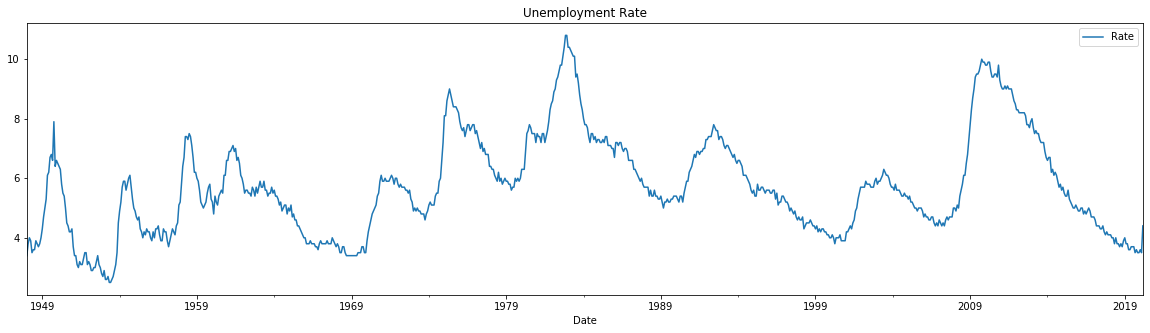

In [3]:
data.plot(figsize=(20,5))
plt.legend(loc='best')
plt.title('Unemployment Rate')
plt.show(block=False)

In [4]:
data_boxcox = pd.Series(boxcox(data['Rate'], lmbda=0), index=data.index)
data_boxcox

Date
1948-01-01    1.223775
1948-02-01    1.335001
1948-03-01    1.386294
1948-04-01    1.360977
1948-05-01    1.252763
                ...   
2019-11-01    1.252763
2019-12-01    1.252763
2020-01-01    1.280934
2020-02-01    1.252763
2020-03-01    1.481605
Length: 867, dtype: float64

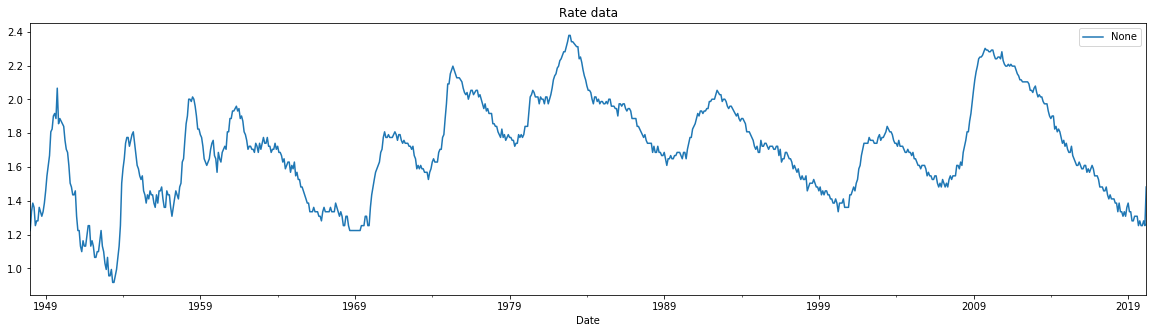

In [5]:
data_boxcox.plot(figsize=(20, 5))
plt.legend(loc='best')
plt.title("Rate data")
plt.show(block=False)

### Differencing

In [6]:
data_boxcox_diff = pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_diff.dropna(inplace=True)

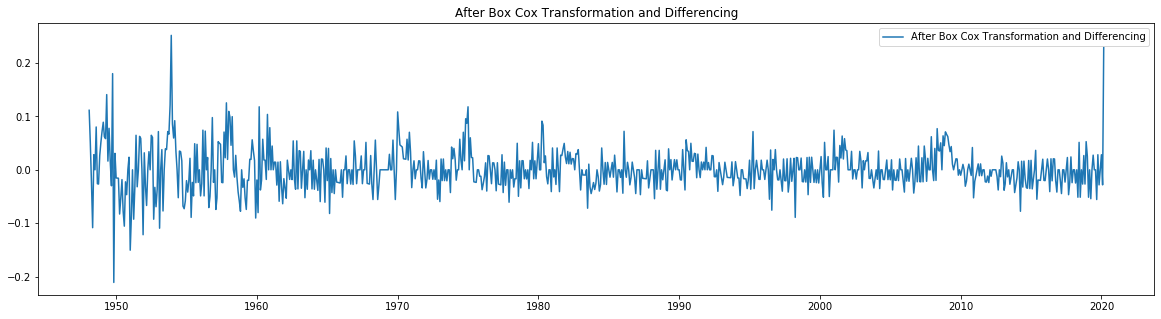

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.title('After Box Cox Transformation and Differencing')
plt.show()

#### ACF plot

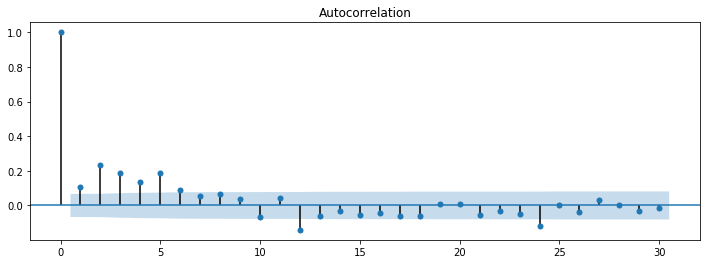

In [8]:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#### PACF plot

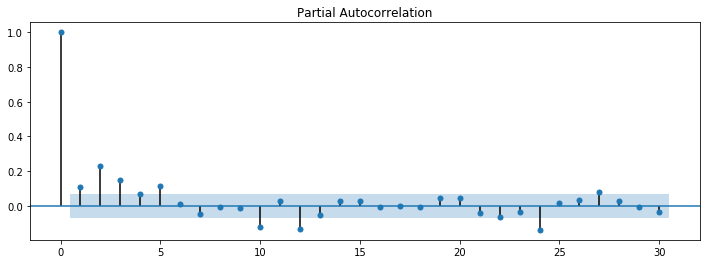

In [9]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

In [10]:
train_len = 612
train = data[:train_len]
test = data[train_len:]

In [11]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [12]:
model = ARIMA(train_data_boxcox_diff.dropna(), order =(12, 0, 0)) # ar(12) model
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060691
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


In [13]:
data_boxcox_diff.shape


(866,)

In [14]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max()) #predict
# recover step by step
y_hat_ar['ar_forecast_boxcox'] =y_hat_ar['ar_forecast_boxcox_diff'].cumsum() # undo the differencing. 
y_hat_ar['ar_forecast_boxcox'] =  y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0]) # add first term that was deleted during differencing
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox']) # reverse of log. 

In [15]:
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ar['ar_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Rate'] - y_hat_ar['ar_forecast'][train_len-1:])/test['Rate'])*100, 2)
rmse,mape

(1.83, 23.62)

In [16]:
y_hat_ar['ar_forecast']['1948-06-01']

4.210203790301734

## MA5

In [17]:
model_5 = ARIMA(train_data_boxcox_diff.dropna(), order =(0, 0,5)) # ar(12) model_5
model_5_fit = model_5.fit()
print(model_5_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [18]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast5_boxcox_diff'] = model_5_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max()) #predict
# recover step by step
y_hat_ar['ar_forecast5_boxcox'] =y_hat_ar['ar_forecast5_boxcox_diff'].cumsum() # undo the differencing. 
y_hat_ar['ar_forecast5_boxcox'] =  y_hat_ar['ar_forecast5_boxcox'].add(data_boxcox[0]) # add first term that was deleted during differencing
y_hat_ar['ar_forecast5'] = np.exp(y_hat_ar['ar_forecast5_boxcox']) # reverse of log. 

In [19]:
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ar['ar_forecast5'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Rate'] - y_hat_ar['ar_forecast5'][train_len-1:])/test['Rate'])*100, 2)
rmse,mape

(1.82, 24.26)

In [20]:
y_hat_ar['ar_forecast5']['1948-06-01']

4.141526587505121

## ARIMA

In [21]:
model = ARIMA(train_data_boxcox, order = (12, 1,5))  #use boxcox instead of data_boxcox_diff
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const         0.000474
ar.L1.D.y    -0.436416
ar.L2.D.y     0.811796
ar.L3.D.y     0.774879
ar.L4.D.y    -0.551921
ar.L5.D.y    -0.813971
ar.L6.D.y     0.075923
ar.L7.D.y     0.064766
ar.L8.D.y     0.069036
ar.L9.D.y     0.186881
ar.L10.D.y    0.020261
ar.L11.D.y   -0.072671
ar.L12.D.y   -0.068804
ma.L1.D.y     0.465935
ma.L2.D.y    -0.640806
ma.L3.D.y    -0.600943
ma.L4.D.y     0.621929
ma.L5.D.y     0.873827
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arima_forecast_boxcox_diff'] =  model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox_diff'].cumsum()
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arima_forecast'] = np.exp(y_hat_arma['arima_forecast_boxcox'])

In [23]:
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ar['ar_forecast5'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Rate'] - y_hat_ar['ar_forecast5'][train_len-1:])/test['Rate'])*100, 2)
rmse,mape

(1.82, 24.26)